In [239]:
import pandas as pd
import numpy as np

## Extracting weight & bias matrices from csv files


In [240]:
def get_matrices(file_path):
    df = pd.read_csv(file_path,header=None)
    grouped = df.groupby(df.columns[0])
    weight_matrices = {}

    for name, group in grouped:
        weight_matrix = group.values.tolist()
        weight_matrices[name] = weight_matrix
    
    #clean up the weight matrices - remove the first column/remove nan values
    for key in weight_matrices:
        cleaned_matrix = []
        for row in weight_matrices[key]:
            row = row[1:]
            row = [value for value in row if not pd.isna(value)]
            cleaned_matrix.append(row)
        weight_matrices[key] = cleaned_matrix
    
    return weight_matrices


In [241]:
csv_file_path = './Task_1/b/w-100-40-4.csv'
weights = get_matrices(csv_file_path)
# for layer_pair, matrix in weights.items():
#     print(f"Weights for {layer_pair}:")
#     for row in matrix:
#         print(row)

In [242]:
csv_file_path = './Task_1/b/b-100-40-4.csv'
biases = get_matrices(csv_file_path)
# print(biases)
# for layer, matrix in biases.items():
#     print(f"Biases for {layer}:")
#     for row in matrix:
#         print(row)

## Defining Activation functions & Error functions

### Rectified linear unit (ReLU)

In [243]:
def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

### Softmax Function

In [244]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### Cross Entrophy Loss Function with Soft Max

In [245]:
def cross_entropy_loss(y, y_hat):
    return -np.sum(y*np.log(y_hat))/y.shape[0]

## Neural Network implementation with Forward and Backward propagation

- Derivative of the Cross Entropy Loss

     \[ \delta = \hat{y} - y_{\text{true}} \]

- Gradient of the error for hidden layers with respect to weighted input

     \[ \delta_i = \delta_{i+1} \cdot W_{i+1}^T \cdot \text{ReLU}'(z_i) \]

- Gradient of the weights

     \[ \frac{\partial L}{\partial W_i} = \frac{1}{m} \cdot \delta_i \cdot a_{i-1}^T \]

- Gradient of the biases

     \[ \frac{\partial L}{\partial b_i} = \frac{1}{m} \cdot \sum_{j=1}^{m} \delta_i^{(j)} \]

In [246]:
class NeuralNetwork:
    def __init__(self, weights, biases):
        self.weights = {k: np.array(v) for k, v in weights.items()}
        self.biases = {k: np.array(v) for k, v in biases.items()}

    def forward(self, input):
        """
        `activations` is a 2D list to store activation function outputs for each layer. 
        at the beginning, it only contains the input

        `before_activation` is a 2D list to store the weighted sum of the input and the bias for each layer
        """
        activations = [input]
        before_activation = []
        #input & hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[f'weights btw layer{i} to layer{i+1}']) + self.biases[f'bias for layer{i+1}']
            before_activation.append(z)
            activations.append(relu(z)) 

        #output layer
        z = np.dot(activations[-1], self.weights[f'weights btw layer{len(self.weights) - 1} to layer{len(self.weights)}']) + self.biases[f'bias for layer{len(self.weights)}']
        before_activation.append(z)
        activations.append(softmax(z))

        return activations, before_activation
    
    def backward(self, X, y_true, activations, z_values):
        m = y_true.shape[0]
        # Derivative of cross-entropy loss with respect to logits
        deltas = [activations[-1] - y_true]
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[-1], self.weights[f'weights btw layer{i+1} to layer{i+2}'].T) * relu_derivative(z_values[i])
            deltas.append(delta)
        deltas.reverse()


        grad_weights = [np.zeros_like(w) for w in self.weights]
        grad_biases = [np.zeros_like(b) for b in self.biases]

        for i in range(len(self.weights)):
            grad_weights[i] = np.dot(activations[i].T, deltas[i]) / m
            grad_biases[i] = np.sum(deltas[i], axis=0) / m

        return grad_weights, grad_biases
    
    def gradient_descent(self, grad_weights, grad_biases, learning_rate):
        for i in range(len(self.weights)):            
            self.weights[f'weights btw layer{i} to layer{i+1}'] -= learning_rate * grad_weights[i]
            self.biases[f'bias for layer{i+1}'] -= learning_rate * grad_biases[i]
        
    def train(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        num_classes = np.max(y_train) + 1
        y_train_encoded = np.eye(num_classes)[y_train.flatten()]
        y_test_encoded = np.eye(num_classes)[y_test.flatten()]

        train_loss_values = []
        test_loss_values = []
        train_accuracy_values = []
        test_accuracy_values = []

        for epoch in range(epochs):
            activations, z_values = self.forward(x_train)
            grad_weights, grad_biases = self.backward(x_train, y_train_encoded, activations, z_values)
            
            train_loss = cross_entropy_loss(y_train_encoded, activations[-1])
            train_loss_values.append(train_loss)

            self.gradient_descent(grad_weights, grad_biases, learning_rate)

            # Compute test loss and accuracy
            test_activations, _ = self.forward(x_test)
            test_loss = cross_entropy_loss(y_test_encoded, test_activations[-1])
            test_loss_values.append(test_loss)

            train_predictions = np.argmax(activations[-1], axis=1)
            test_predictions = np.argmax(test_activations[-1], axis=1)

            train_accuracy = np.mean(train_predictions == y_train.flatten())
            test_accuracy = np.mean(test_predictions == y_test.flatten())

            train_accuracy_values.append(train_accuracy)
            test_accuracy_values.append(test_accuracy)

            # if epoch % 100 == 0:
                # print(f"Epoch {epoch}: Loss = {loss}")

        return train_loss_values, test_loss_values, train_accuracy_values, test_accuracy_values

    def predict(self, x_test):
        activations, _ = self.forward(x_test)
        return np.argmax(activations[-1], axis=1)
    



## Calculating Gradients for Task 01

In [273]:
nn = NeuralNetwork(weights, biases)

In [274]:
input = np.array([[-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]])
y_true = np.array([[0, 0, 0, 1]])

activations, z_values = nn.forward(input)
grad_weights, grad_biases = nn.backward(input, y_true, activations, z_values)



## Converting to CSV files

In [279]:
def save_gradients_to_csv(grad_weights, filename):
    with open(filename, mode='w', newline='') as file:
        for value in grad_weights:
            df = pd.DataFrame(value) #.astype(np.float32)
            df.to_csv(file, header=False, index=False)

def save_grad_biases_to_csv(grad_biases, filename):
    with open(filename, mode='w', newline='') as file:
        for value in grad_biases:
            df = pd.DataFrame(value).T #.astype(np.float32)  # Transpose to match the expected format
            df.to_csv(file, header=False, index=False)

In [278]:
save_gradients_to_csv(grad_weights, 'dw_0.csv')

In [280]:
save_grad_biases_to_csv(grad_biases, 'db_0.csv')

# Task 02 - Training the NN

In [251]:
x_train = pd.read_csv('./Task_2/x_train.csv', header=None).values
y_train = pd.read_csv('./Task_2/y_train.csv', header=None).values
x_test = pd.read_csv('./Task_2/x_test.csv', header=None).values
y_test = pd.read_csv('./Task_2/y_test.csv', header=None).values

### Learning Rate = 0.01

In [252]:
NN_01 = NeuralNetwork(weights, biases)

In [253]:
train_loss_values1, test_loss_values1, train_accuracy_values1, test_accuracy_values1  = NN_01.train(x_train, y_train, x_test, y_test,  epochs=2000, learning_rate=0.1)

/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y*np.log(y_hat))/y.shape[0]
/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y*np.log(y_hat))/y.shape[0]


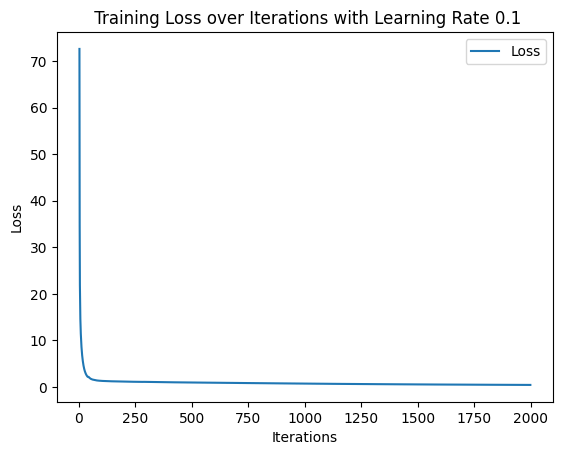

In [254]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_values1)), train_loss_values1, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Training Loss over Iterations with Learning Rate 0.1')
plt.legend()
plt.show()

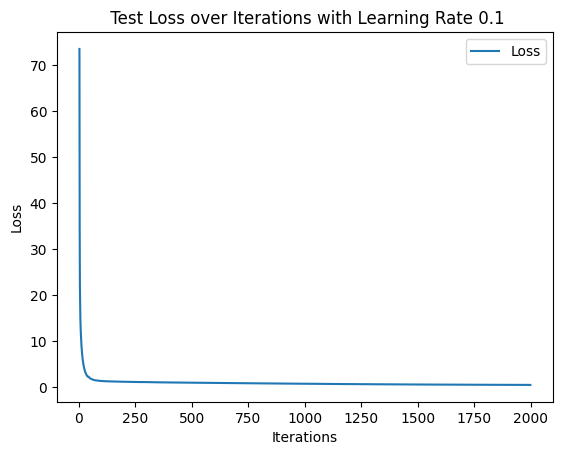

In [255]:
plt.plot(range(len(test_loss_values1)), test_loss_values1, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Test Loss over Iterations with Learning Rate 0.1')
plt.legend()
plt.show()

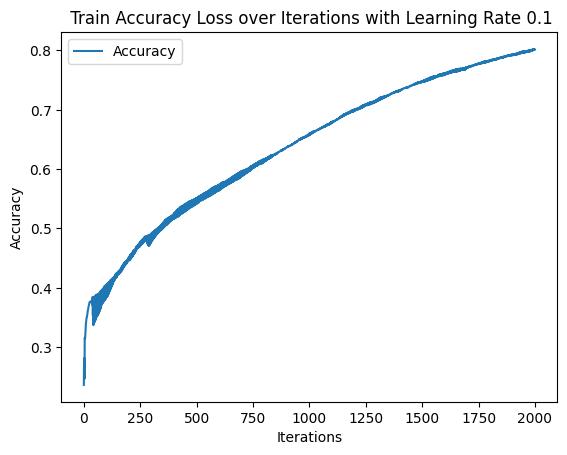

In [256]:
plt.plot(range(len(train_accuracy_values1)), train_accuracy_values1, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Train Accuracy Loss over Iterations with Learning Rate 0.1')
plt.legend()
plt.show()

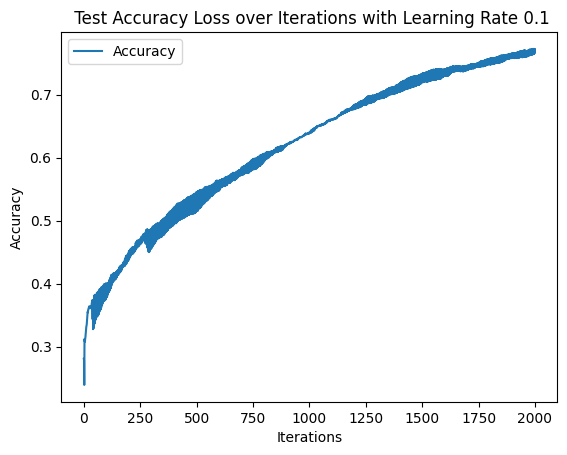

In [257]:
plt.plot(range(len(test_accuracy_values1)), test_accuracy_values1, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Test Accuracy Loss over Iterations with Learning Rate 0.1')
plt.legend()
plt.show()

### Learning Rate = 1

In [258]:
NN_02 = NeuralNetwork(weights, biases)

In [259]:
train_loss_values2, test_loss_values2, train_accuracy_values2, test_accuracy_values2  = NN_02.train(x_train, y_train, x_test, y_test,  epochs=2000, learning_rate= 1)

/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y*np.log(y_hat))/y.shape[0]
/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y*np.log(y_hat))/y.shape[0]


In [226]:
print(train_loss_values2)

[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(2.10330530802709), np.float64(1.641672776130042), np.float64(1.545018993978841), np.float64(1.4871540947696298), np.float64(1.4505796495452992), np.float64(1.4278380460354092), np.float64(1.4141584159659117), np.float64(1.4049255803155138), np.float64(1.398669555329579), np.float64(1.3944418438742245), np.float64(1.3914993060099434), np.float64(1.389181362628338), np.float64(1.387174770576408), np.float64(1.3856814555089718), np.float64(1.3845804549373555), np.float64(1.383655120576831), np.float64(1.3828290676942183), np.float64(1.3820722011504187), np.float64(1.3814231813068567), np.float64(1.3807749636123718), np.float64(1.3802110219637302), np.float64(1.3797004819513894), np.float64(1.3792584228863884), np.float64(1.378864479500757), np.float64(1.3784889027001592), np.float64(1.378137913262639), np.float64(1.377804107646139), np.float64(1.3774973445797758), np.float64(1.3771729618308175), np.float64(1.376911275702996), 

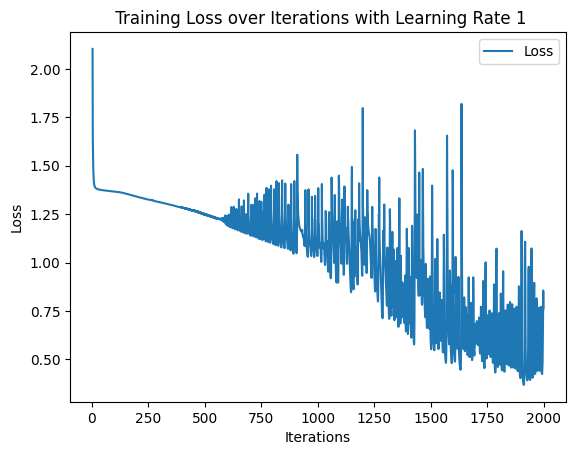

In [260]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_values2)), train_loss_values2, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Training Loss over Iterations with Learning Rate 1')
plt.legend()
plt.show()

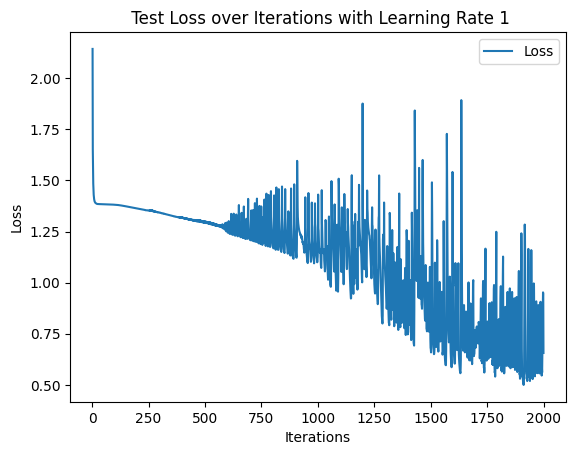

In [261]:
plt.plot(range(len(test_loss_values2)), test_loss_values2, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Test Loss over Iterations with Learning Rate 1')
plt.legend()
plt.show()

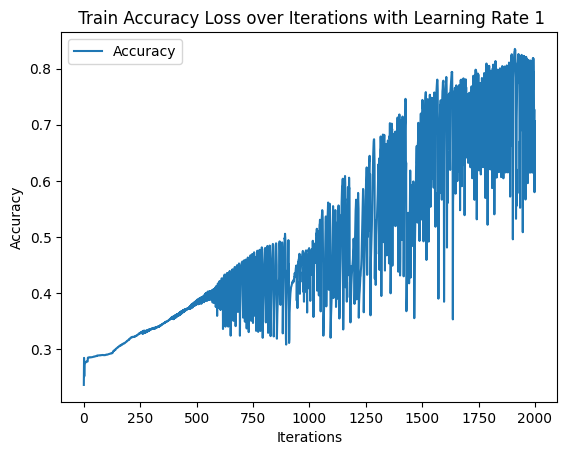

In [266]:
plt.plot(range(len(train_accuracy_values2)), train_accuracy_values2, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Train Accuracy Loss over Iterations with Learning Rate 1')
plt.legend()
plt.show()

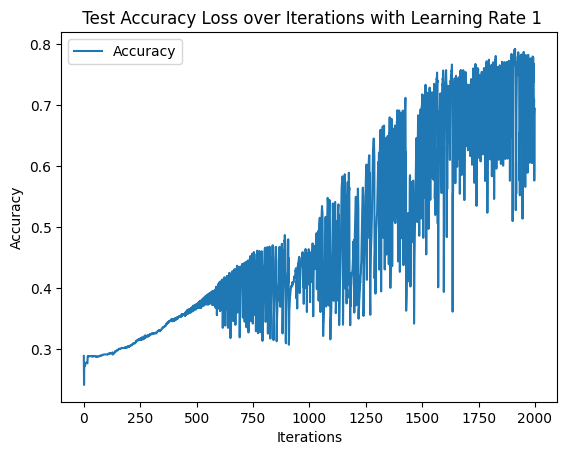

In [267]:
plt.plot(range(len(test_accuracy_values2)), test_accuracy_values2, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Test Accuracy Loss over Iterations with Learning Rate 1')
plt.legend()
plt.show()

### Leaning Rate = 0.001

In [264]:
NN_03 = NeuralNetwork(weights, biases)

In [265]:
train_loss_values3, test_loss_values3, train_accuracy_values3, test_accuracy_values3  = NN_03.train(x_train, y_train, x_test, y_test,  epochs=2000, learning_rate= 0.001)

/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y*np.log(y_hat))/y.shape[0]
/var/folders/xz/zslq9hk108nbjz1zz8tsnff80000gn/T/ipykernel_80947/2098895936.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y*np.log(y_hat))/y.shape[0]


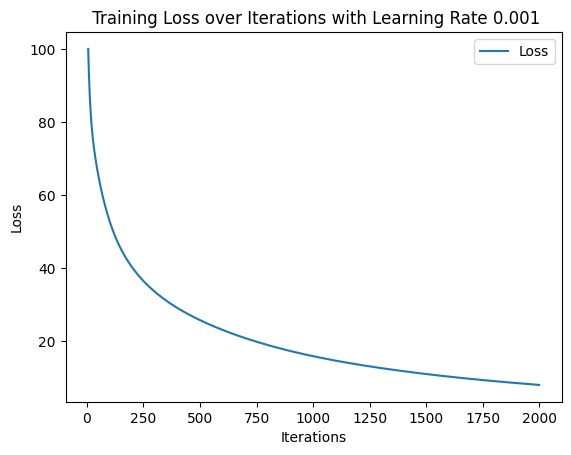

In [268]:
plt.plot(range(len(train_loss_values3)), train_loss_values3, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Training Loss over Iterations with Learning Rate 0.001')
plt.legend()
plt.show()

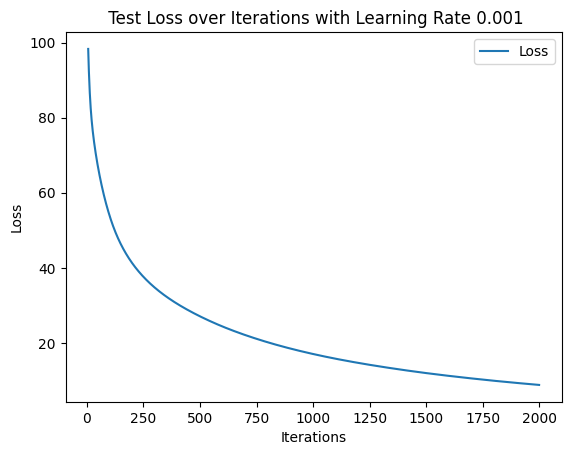

In [269]:
plt.plot(range(len(test_loss_values3)), test_loss_values3, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' Test Loss over Iterations with Learning Rate 0.001')
plt.legend()
plt.show()

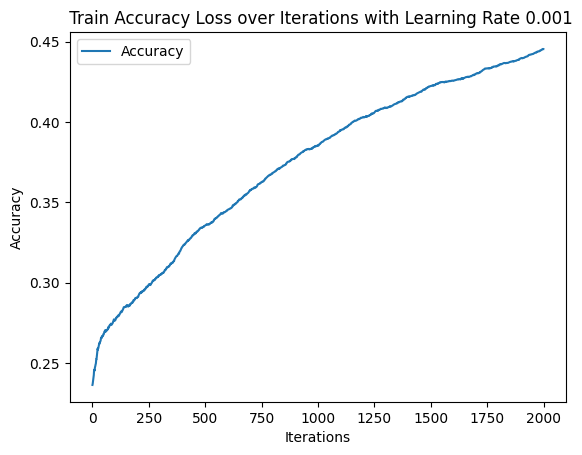

In [270]:
plt.plot(range(len(train_accuracy_values3)), train_accuracy_values3, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Train Accuracy Loss over Iterations with Learning Rate 0.001')
plt.legend()
plt.show()

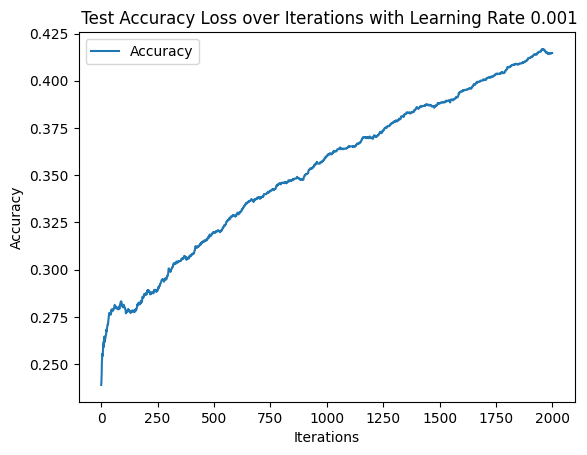

In [272]:
plt.plot(range(len(test_accuracy_values3)), test_accuracy_values3, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title(' Test Accuracy Loss over Iterations with Learning Rate 0.001')
plt.legend()
plt.show()